# Scientific Computing: Diffusion Limited Aggregation and Reaction Diffusion

## Imports

In [1]:
import numpy as np
from IPython.display import HTML

import src.solutions as solutions
import src.visualizations as visualizations

In [2]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pickle as pkl
import os


## Diffusion Limited Aggregation

### Parameter Values

In [ ]:

N = 100
eta = 1
tol = 1e-4
maxiters = 10000
omega = 1.8
cluster_size = 750
etas = [0.3, 0.5, 0.7, 1, 1.3]
omegas = np.linspace(1.4, 2, 7)
omegas = np.delete(omegas, -1)

grid_indices = np.arange(N*N)
itertjes = 1500
np.round(omegas,1)
print(omegas)

# optimal omegas, determined with experimentation
opp_omm = [1.5, 1.6, 1.6, 1.6, 1.7]
opt_omegas = dict()
for i, e in enumerate(etas):
    opt_omegas[e] = opp_omm[i]

#### Initialization
creating an initial grid by placing object at the bottom of the 2D grid.   
The grid has a source at the top of the grid.   
within SOR, being part of the object is resembled with concentration of 0

In [ ]:
object_grid = solutions.place_objects(N)
grid = solutions.initialize_grid(N, object_grid)
iters, grid = solutions.parallel_SOR(grid, tol, maxiters, omega, object_grid)
assert iters < maxiters, f"No convergence for SOR, omega: {omega} "

visualizing diffusion grid along with object (grid is turned 180 degrees)  
object is placed in 0 diffusion zone. 

In [ ]:
# normalized_grid = normalize_concentration(grid)
visualizations.plot_simulation_without_animation(grid, N, object_grid)
solutions.save_grid_to_file(grid)

#### Update initialized grid
run the DLA by solving the Laplace formula of the grid,  
calculating the cell connection probabilities with each cell concentration,  
and by selecting potential new cells joining the object (north, east, south, west) neighbors of the object. 
Update the grid by adding the selected cell to the object and rerunning these steps. 

Visualization of this process is provided here. 

### Animation of the DLA Process for Different Eta Values

In [ ]:
if omega != 1.7:
    omega = 1.7
    iters, grid = solutions.parallel_SOR(grid, tol, maxiters, omega, object_grid)     
    assert iters < maxiters, f"No convergence for SOR, omega: {omega} "
    
for eta in etas:

    # copy initial grid to save computation time
    iter_grid = np.copy(grid)
    object_grid_iter = np.copy(object_grid)

    # choose precomputed optimal omega for the specific eta
    omega = opt_omegas[eta]

    # pack the parameters for SOR
    Sr_pars = (tol, maxiters, omega)

    # generate the initial neighbors that can be chosen to add to the object
    stencil_iter = solutions.generate_stencil(object_grid_iter)
    seedje = 22
    print(f"starting animation for DLA, eta: {eta}")

    # render visualization (updates are done dynamically)
    ani = visualizations.animate_1a(iter_grid, stencil_iter, object_grid_iter, grid_indices, eta, seedje, Sr_pars)


### Computation of the average number of iterations for a SOR convergence step for Different Omega Values (Run Over 10 Different Grids )

In [ ]:
itertjes = 750
seedje=22

eta_lijstje, grid_lijstje, all_itertjes = solutions.optimize_omega_DLA(itertjes, etas, seedje, omegas, grid, object_grid, tol, maxiters, grid_indices)

### Visualization of Average Iterations for Each SOR Convergence Step for Different Omega Values

In [ ]:
best_omegas = visualizations.plot_omega_vs_iterations(omegas, all_itertjes)
for eetje, ommetje in best_omegas.items():
    print(f"For eta:  {eetje},  the optimal omega is {ommetje} ")

### Visualization of Clusters for Different Eta Values

In [ ]:
visualizations.plot_five_DLA(grid_lijstje, etas)

### B. Implement the Monte Carlo version of DLA. Compare the resulting cluster to those obtained with the diffusion equation.

In [4]:
# Initial parameters for the DLA simulation using random walkers
N = 100
cluster_size = 750
p_join_standard = 1.0

# Evolution of diffusion using random walkers
all_grids = solutions.monte_carlo_dla(N, p_join_standard, cluster_size, animation=True)
animation = visualizations.animate_mc_dla(all_grids)

HTML(animation.to_jshtml())

: 

### C. Run the simulation for different values of ps, and plot the results. How does the cluster shape depend on Ps?

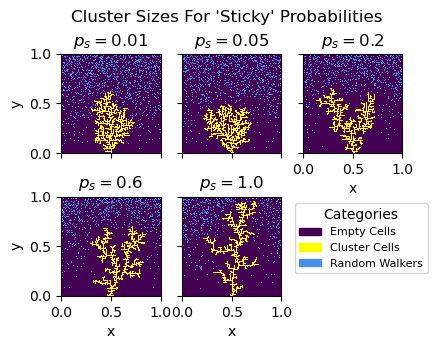

In [ ]:
N = 100
cluster_size = 750
probs = [0.01, 0.05, 0.2, 0.6, 1.0]
probs_grids = []
save_prob_grids = False

# Existing data file, re-running takes approximately 30 minutes
file_path = "data/probabilities_grids.pkl"

if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        probs_grids = pkl.load(f)
        #print(probs_grids)
else:
    for prob in probs:
        grids = solutions.monte_carlo_dla(N, prob, cluster_size)
        probs_grids.append(grids[0])

if save_prob_grids:
    with open(file_path, "wb") as f:
        pkl.dump(probs_grids, f)


visualizations.visualize_for_different_probs(probs_grids, probs)

#### D. Implementation of the Gray-Scott model in 2D with periodic boundary conditions for a N x N grid. The implementation is parallelized over rows for the Laplace equation used. For initial conditions, u = 0.5 is taken everywhere in the system, v = 0.25 is taken in a small square in the center of the system. A small amount of noise is added in the center of the system for both U and V. The resulting concentration of U is plotted for different parameter values. 

In [ ]:
# parameters
N = 300  # grid size
num_steps = 15000  # number of time steps
dt = 1 # time step size
dx = 1 # grid spacing
noise_level = 0.01 # noise level
output_dir = "plots"

# parameter sets for f (first) and k (second) - 1
param_sets_f_k = [
    (0.025, 0.050),
    (0.045, 0.060),
    (0.062, 0.061),
    (0.062, 0.062)
]

# first diffusion coefficient pairs - 1
param_sets_Du_Dv_1 = (0.16, 0.08)

# store final results of U concentration for plotting - 1
u_final_list_1 = []

# iterate through f and k values - 1
for f, k in param_sets_f_k:
    Du_1, Dv_1 = param_sets_Du_Dv_1 # test for Du=0.16, Dv=0.08
    u_final_1, _ = solutions.run_simulation_gray_scott(N, num_steps, dt, dx, Du_1, Dv_1, f, k, noise_level)
    u_final_list_1.append(u_final_1)

# plot the final concentrations of U for the tested parameter sets - 1
visualizations.plot_final_gray_scott(u_final_list_1, param_sets_f_k, N, output_dir, plot_number=1)

# second diffusion coefficient pairs - 2
param_sets_Du_Dv_2 = (0.20, 0.08)

# store final results of U concentration for plotting - 2
u_final_list_2 = []

# iterate through f and k values - 2
for f, k in param_sets_f_k:
    Du_2, Dv_2 = param_sets_Du_Dv_2 # test for Du=0.20, Dv=0.08
    u_final_2, _ = solutions.run_simulation_gray_scott(N, num_steps, dt, dx, Du_2, Dv_2, f, k, noise_level)
    u_final_list_2.append(u_final_2)

# plot the final concentrations of U for the tested parameter sets - 2
visualizations.plot_final_gray_scott(u_final_list_2, param_sets_f_k, N, output_dir, plot_number=2)